## Directory and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/NAS_BraggNN/BraggNN

/content/drive/MyDrive/NAS_BraggNN/BraggNN


In [3]:
import torch
import torch.nn as nn
import torch.quantization
# from updated_dataset import BraggNNDataset # commented out: use when in braggnn env
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from functools import partial
import os
from datetime import datetime
import time

## PyTorch Model

In [5]:
class TorchNAC(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.block1 = nn.Sequential(
            nn.Conv2d(32, 4, 1, 1), #nn.Linear(32, 4), #Point-wise Convolution
            nn.ReLU(),
            nn.Conv2d(4, 32, 1, 1), #nn.Linear(4, 32), #Point-wise Convolution
            nn.BatchNorm2d(32),
            nn.LeakyReLU() #nn.LeakyReLU() (tried out to see if would get a smaller delta is used relu - not the case)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 4, 1, 1), #nn.Linear(32, 4), #Point-wise Convolution
            nn.BatchNorm2d(4),
            nn.LeakyReLU(), #nn.GELU(), (hls4ml not supported)
            nn.Conv2d(4, 32, 3, 1),
            nn.BatchNorm2d(32), #nn.LayerNorm((32, 7, 7)), (hls4ml not supported)
            nn.LeakyReLU() #nn.GELU() (hls4ml not supported)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 8, 3, 1),
            nn.BatchNorm2d(8), #nn.LayerNorm((8, 5, 5)), (hls4ml not supported)
            nn.LeakyReLU(), #nn.GELU(), (hls4ml not supported)
            nn.Conv2d(8, 64, 3, 1),
        )
        self.flatten = nn.Flatten() # added this for hls4ml support
        self.mlp = nn.Sequential(
            nn.Linear(576, 8),
            nn.BatchNorm1d(8), #nn.LayerNorm((8)), (hls4ml not supported)
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.LeakyReLU(), #nn.GELU(), (hls4ml not supported)
            nn.Linear(4,4),
            nn.BatchNorm1d(4), #nn.LayerNorm((4)), (hls4ml not supported)
            nn.LeakyReLU(), #nn.GELU(), (hls4ml not supported)
            nn.Linear(4,2),
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x) #torch.flatten(x,1) # removed this as hls4ml does not support it
        x = self.mlp(x)
        return x

In [6]:
pytorch_model = TorchNAC()

pytorch_model.cpu()

print(pytorch_model)

TorchNAC(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (block1): Sequential(
    (0): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (block2): Sequential(
    (0): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (block3): Sequential(
    (0): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(8, 64, kernel_

In [7]:
import torch

pytorch_model_path = 'model_weights_300_epochs.pth'

# Load the state dictionary from the file directly
pytorch_state_dict = torch.load(pytorch_model_path, map_location=torch.device('cpu'))

# Load the state dictionary into the model
pytorch_model.load_state_dict(pytorch_state_dict)

pytorch_model.eval()

TorchNAC(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (block1): Sequential(
    (0): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (block2): Sequential(
    (0): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (block3): Sequential(
    (0): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(8, 64, kernel_

In [8]:
# Check the keys
for key in pytorch_state_dict.keys():
    print(key)

conv1.weight
conv1.bias
block1.0.weight
block1.0.bias
block1.2.weight
block1.2.bias
block1.3.weight
block1.3.bias
block1.3.running_mean
block1.3.running_var
block1.3.num_batches_tracked
block2.0.weight
block2.0.bias
block2.1.weight
block2.1.bias
block2.1.running_mean
block2.1.running_var
block2.1.num_batches_tracked
block2.3.weight
block2.3.bias
block2.4.weight
block2.4.bias
block2.4.running_mean
block2.4.running_var
block2.4.num_batches_tracked
block3.0.weight
block3.0.bias
block3.1.weight
block3.1.bias
block3.1.running_mean
block3.1.running_var
block3.1.num_batches_tracked
block3.3.weight
block3.3.bias
mlp.0.weight
mlp.0.bias
mlp.1.weight
mlp.1.bias
mlp.1.running_mean
mlp.1.running_var
mlp.1.num_batches_tracked
mlp.3.weight
mlp.3.bias
mlp.5.weight
mlp.5.bias
mlp.6.weight
mlp.6.bias
mlp.6.running_mean
mlp.6.running_var
mlp.6.num_batches_tracked
mlp.8.weight
mlp.8.bias


## TF model

In [ ]:
#!pip install tensorflow

In [55]:
# Changed architecture for tf

import tensorflow as tf
from tensorflow.keras import layers, models

class NAC(models.Model):
    def __init__(self):
        super(NAC, self).__init__()
        self.conv1 = layers.Conv2D(32, kernel_size=3, strides=1, padding='valid', input_shape=(11, 11, 1)) # 11x11 with 1 channel

        self.block1 = models.Sequential([
            layers.Conv2D(4, 1, strides=1, padding='valid'),
            layers.ReLU(),
            layers.Conv2D(32, 1, strides=1, padding='valid'),
            layers.BatchNormalization(),
            layers.LeakyReLU()
        ])

        self.block2 = models.Sequential([
            layers.Conv2D(4, 1, strides=1, padding='valid'),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2D(32, 3, strides=1, padding='valid'),
            layers.BatchNormalization(),
            layers.LeakyReLU()
        ])

        self.block3 = models.Sequential([
            layers.Conv2D(8, 3, strides=1, padding='valid'),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2D(64, 3, strides=1, padding='valid')
        ])

        self.flatten = layers.Flatten()
        self.mlp = models.Sequential([
            layers.Dense(8), # input feature size is implicit (should be 576, was 1600 -> changed all padding to 'valid' iso 'same')
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(4),
            layers.LeakyReLU(),
            layers.Dense(4),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Dense(2)
        ])

    def call(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.mlp(x)
        return x

In [10]:
with tf.device('/CPU:0'):  # '/GPU:0' to use the GPU; '/CPU:0' to use the CPU
    tf_model = NAC()  # TF model

In [11]:
# Model's architecture
tf_model.build((None, 11, 11, 1))  # Input shape is (11, 11, 1)
tf_model.summary()

Model: "nac"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  320       
                                                                 
 sequential (Sequential)     (None, 9, 9, 32)          420       
                                                                 
 sequential_1 (Sequential)   (None, 7, 7, 32)          1460      
                                                                 
 sequential_2 (Sequential)   (None, 3, 3, 64)          7016      
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 sequential_3 (Sequential)   (None, 2)                 4730      
                                                                 
Total params: 13946 (54.48 KB)
Trainable params: 13770 (53.79 K

## Transpose and Assign Weights to Keras Model

Move the respective PyTorch tensor to CPU and convert to numpy array:
.cpu().numpy()

The below is very recursive, initially designed to check each layer

For reference: pytorch: (out_channels, in_channels, height, width); tf: (height, width, in_channels, out_channels)

In [1]:
## Todo: iterate through the keys:
# for key in pytorch_state_dict.keys():
#     print(key)
## loop through abd convert the weights (trasnspose), and everything else (bias, running_mean, running_var, num_batches_tracked)
## instead of the below

In [12]:
# Transpose and set weights for the 'conv1' layer in tf model
conv1_weight = pytorch_state_dict['conv1.weight'].cpu().numpy().transpose((2, 3, 1, 0))
conv1_bias = pytorch_state_dict['conv1.bias'].cpu().numpy()

tf_model.conv1.set_weights([conv1_weight, conv1_bias])

block 1

In [13]:
# block1 - first conv2d layer

block1_conv1_weight = pytorch_state_dict['block1.0.weight'].cpu().numpy().transpose((2, 3, 1, 0))
block1_conv1_bias = pytorch_state_dict['block1.0.bias'].cpu().numpy()

tf_model.block1.layers[0].set_weights([block1_conv1_weight, block1_conv1_bias])


In [14]:
# block1 - second conv2d layer

block1_conv2_weight = pytorch_state_dict['block1.2.weight'].cpu().numpy().transpose((2, 3, 1, 0))
block1_conv2_bias = pytorch_state_dict['block1.2.bias'].cpu().numpy()

tf_model.block1.layers[2].set_weights([block1_conv2_weight, block1_conv2_bias])


In [15]:
# block1 - BatchNorm layer

block1_bn_gamma = pytorch_state_dict['block1.3.weight'].cpu().numpy()
block1_bn_beta = pytorch_state_dict['block1.3.bias'].cpu().numpy()
block1_bn_running_mean = pytorch_state_dict['block1.3.running_mean'].cpu().numpy()
block1_bn_running_var = pytorch_state_dict['block1.3.running_var'].cpu().numpy()

tf_model.block1.layers[3].set_weights([block1_bn_gamma, block1_bn_beta, block1_bn_running_mean, block1_bn_running_var])

# Need this too?
# block1.3.num_batches_tracked


block 2

In [16]:
# block2 - first conv2d layer

block2_conv1_weight = pytorch_state_dict['block2.0.weight'].cpu().numpy().transpose((2, 3, 1, 0))
block2_conv1_bias = pytorch_state_dict['block2.0.bias'].cpu().numpy()

# Assign weights to the corresponding layer
tf_model.block2.layers[0].set_weights([block2_conv1_weight, block2_conv1_bias])


In [17]:
# block2 - first BatchNorm layer

block2_bn1_gamma = pytorch_state_dict['block2.1.weight'].cpu().numpy()
block2_bn1_beta = pytorch_state_dict['block2.1.bias'].cpu().numpy()
block2_bn1_running_mean = pytorch_state_dict['block2.1.running_mean'].cpu().numpy()
block2_bn1_running_var = pytorch_state_dict['block2.1.running_var'].cpu().numpy()

# Assign weights to the corresponding layer in the Keras model
tf_model.block2.layers[1].set_weights([block2_bn1_gamma, block2_bn1_beta, block2_bn1_running_mean, block2_bn1_running_var])


In [18]:
# block2 - second conv2d layer

block2_conv2_weight = pytorch_state_dict['block2.3.weight'].cpu().numpy().transpose((2, 3, 1, 0))
block2_conv2_bias = pytorch_state_dict['block2.3.bias'].cpu().numpy()

# Assign weights to the corresponding layer
tf_model.block2.layers[3].set_weights([block2_conv2_weight, block2_conv2_bias])


In [19]:
# block2 - second BatchNorm layer

block2_bn2_gamma = pytorch_state_dict['block2.4.weight'].cpu().numpy()
block2_bn2_beta = pytorch_state_dict['block2.4.bias'].cpu().numpy()
block2_bn2_running_mean = pytorch_state_dict['block2.4.running_mean'].cpu().numpy()
block2_bn2_running_var = pytorch_state_dict['block2.4.running_var'].cpu().numpy()

# Assign weights to the corresponding layer
tf_model.block2.layers[4].set_weights([block2_bn2_gamma, block2_bn2_beta, block2_bn2_running_mean, block2_bn2_running_var])


block 3

In [20]:
# block3 - first conv2d layer

block3_conv1_weight = pytorch_state_dict['block3.0.weight'].cpu().numpy().transpose((2, 3, 1, 0))
block3_conv1_bias = pytorch_state_dict['block3.0.bias'].cpu().numpy()

# Assign weights to the corresponding layer
tf_model.block3.layers[0].set_weights([block3_conv1_weight, block3_conv1_bias])


In [21]:
# block3 - first BatchNorm layer

block3_bn_gamma = pytorch_state_dict['block3.1.weight'].cpu().numpy()
block3_bn_beta = pytorch_state_dict['block3.1.bias'].cpu().numpy()
block3_bn_running_mean = pytorch_state_dict['block3.1.running_mean'].cpu().numpy()
block3_bn_running_var = pytorch_state_dict['block3.1.running_var'].cpu().numpy()

# Assign weights to the corresponding layer
tf_model.block3.layers[1].set_weights([block3_bn_gamma, block3_bn_beta, block3_bn_running_mean, block3_bn_running_var])


In [22]:
# block3 - second conv2d layer

block3_conv2_weight = pytorch_state_dict['block3.3.weight'].cpu().numpy().transpose((2, 3, 1, 0))
block3_conv2_bias = pytorch_state_dict['block3.3.bias'].cpu().numpy()

# Assign weights to the corresponding layer
tf_model.block3.layers[3].set_weights([block3_conv2_weight, block3_conv2_bias])


MLP

In [23]:
# First Dense layer
mlp_dense1_weight = pytorch_state_dict['mlp.0.weight'].cpu().numpy().transpose()
mlp_dense1_bias = pytorch_state_dict['mlp.0.bias'].cpu().numpy()

tf_model.mlp.layers[0].set_weights([mlp_dense1_weight, mlp_dense1_bias])


In [24]:
# First BatchNorm layer
mlp_bn1_gamma = pytorch_state_dict['mlp.1.weight'].cpu().numpy()
mlp_bn1_beta = pytorch_state_dict['mlp.1.bias'].cpu().numpy()
mlp_bn1_running_mean = pytorch_state_dict['mlp.1.running_mean'].cpu().numpy()
mlp_bn1_running_var = pytorch_state_dict['mlp.1.running_var'].cpu().numpy()

tf_model.mlp.layers[1].set_weights([mlp_bn1_gamma, mlp_bn1_beta, mlp_bn1_running_mean, mlp_bn1_running_var])


In [25]:
# Second Dense layer
mlp_dense2_weight = pytorch_state_dict['mlp.3.weight'].cpu().numpy().transpose()
mlp_dense2_bias = pytorch_state_dict['mlp.3.bias'].cpu().numpy()

tf_model.mlp.layers[3].set_weights([mlp_dense2_weight, mlp_dense2_bias])


In [26]:
# Second BatchNorm layer
mlp_bn2_gamma = pytorch_state_dict['mlp.6.weight'].cpu().numpy()
mlp_bn2_beta = pytorch_state_dict['mlp.6.bias'].cpu().numpy()
mlp_bn2_running_mean = pytorch_state_dict['mlp.6.running_mean'].cpu().numpy()
mlp_bn2_running_var = pytorch_state_dict['mlp.6.running_var'].cpu().numpy()

tf_model.mlp.layers[6].set_weights([mlp_bn2_gamma, mlp_bn2_beta, mlp_bn2_running_mean, mlp_bn2_running_var])


In [27]:
# Final Dense layer
mlp_dense_final_weight = pytorch_state_dict['mlp.8.weight'].cpu().numpy().transpose()
mlp_dense_final_bias = pytorch_state_dict['mlp.8.bias'].cpu().numpy()

tf_model.mlp.layers[8].set_weights([mlp_dense_final_weight, mlp_dense_final_bias])


In [29]:
# Save tf model

# Save the weights of the model
tf_model.save_weights('tf_model_weights_300.h5')

## Check PyTorch vs TF weights

Check Weight Formats

In [74]:
original_shape = pytorch_state_dict['block1.0.weight'].shape
print("Original PyTorch shape:", original_shape) #(out_channels, in_channels, height, width)

Original PyTorch shape: torch.Size([4, 32, 1, 1])


In [75]:
# Transpose the weights
block1_conv1_weight_transposed = pytorch_state_dict['block1.0.weight'].cpu().numpy().transpose((2, 3, 1, 0))

# Check the transposed shape
print("Transposed shape:", block1_conv1_weight_transposed.shape) #(height, width, in_channels, out_channels)

Transposed shape: (1, 1, 32, 4)


Visually Inspect the weights

In [76]:
# The first convolutional layer's weights
print(pytorch_model.conv1.weight.data.cpu().numpy()[0, 0, :, :])  # First filter of the first channel [first filter, first input channel, , ]


[[-0.08565165 -0.01641661  0.15382989]
 [ 0.11902591 -0.25500783  0.30215153]
 [-0.12986057 -0.2314675  -0.1209302 ]]


In [78]:
# The corresponding layer's weights in Keras
print(tf_model.conv1.get_weights()[0][:, :, 0, 0])  # First filter of the first channel [ , , first filter, first input channel]


[[-0.08565165 -0.01641661  0.15382989]
 [ 0.11902591 -0.25500783  0.30215153]
 [-0.12986057 -0.2314675  -0.1209302 ]]


In [81]:
print(pytorch_model.block1[0].weight.data.cpu().numpy()[0, 0, :, :])  # Block1 PyTorch

[[-0.0642695]]


In [84]:
print(tf_model.block1.get_weights()[0][:, :, 0, 0])  # Block1 TF

[[-0.0642695]]


In [126]:
# # Accessing the first Dense layer's weights in PyTorch and printing the first row
# print(pytorch_model.mlp[0].weight.data.cpu().numpy()[0, :])  # mlp.0.weight PyTorch

# PyTorch: Getting the weights for the first dense layer
weights_pytorch = pytorch_model.mlp[0].weight.data.cpu().numpy()

# First and last 3 elements of the first row
first_elements_pytorch = weights_pytorch[0, :3]  # First 3 elements
last_elements_pytorch = weights_pytorch[0, -3:]  # Last 3 elements

# Print concatenated
print("PyTorch - First Dense layer:", np.concatenate([first_elements_pytorch, last_elements_pytorch]))

PyTorch - First Dense layer: [-0.01225404 -0.03560065 -0.01225035 -0.02751546  0.03630454 -0.02341032]


In [127]:
# # Accessing the first Dense layer's weights in TensorFlow/Keras and printing the first row
# print(tf_model.mlp.layers[0].get_weights()[0][:, 0])  # First Dense layer TF

# TF: Getting the weights for the first dense layer
weights_keras = tf_model.mlp.layers[0].get_weights()[0]

# First and last 3 elements of the first column
first_elements_keras = weights_keras[:3, 0]  # First 3 elements
last_elements_keras = weights_keras[-3:, 0]  # Last 3 elements

print("Keras - First Dense layer:", np.concatenate([first_elements_keras, last_elements_keras]))


Keras - First Dense layer: [-0.01225404 -0.03560065 -0.01225035 -0.02751546  0.03630454 -0.02341032]


Numerical Verification

In [94]:
# Difference in weights of the first convolutional layer
pytorch_weights = pytorch_model.block1[0].weight.data.cpu().numpy()[0, 0, :, :]
keras_weights = tf_model.block1.get_weights()[0][:, :, 0, 0]

print(pytorch_weights.shape)
print(keras_weights.shape)

(1, 1)
(1, 1)


In [128]:
# Calculate the norm of the difference
weight_diff = np.linalg.norm(pytorch_weights - keras_weights)
print("Weight difference", weight_diff)

Weight difference 0.0


Functional Verification

In [117]:
# Create a PyTorch tensor for input
test_input_pytorch = torch.rand(1, 1, 11, 11)  # PyTorch: (batch_size, channels, height, width)

# Convert PyTorch tensor to a NumPy array and adjust for TensorFlow/Keras ('channels last')
test_input_keras = test_input_pytorch.permute(0, 2, 3, 1).numpy()  # TensorFlow/Keras: (batch_size, height, width, channels)

In [118]:
# PyTorch: Use the original tensor
pytorch_model.eval()  # Ensure the model is in evaluation mode
output_pytorch = pytorch_model(test_input_pytorch).detach().cpu().numpy()

# TensorFlow/Keras: Use the adjusted NumPy array
output_keras = tf_model.predict(test_input_keras)

1/1 [==============================] - 0s 24ms/step


In [119]:
# Calculate the difference between outputs
output_diff = np.linalg.norm(output_pytorch - output_keras)
print("Output difference:", output_diff)

# This should be zero, right?

Output difference: 0.95722353


## Load in the Model and convert to hls4ml (very messy and not functioning at the moment, below)

In [52]:
from tensorflow.keras import layers, models

def NAC_sequential():
    model = models.Sequential()

    model.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='valid', input_shape=(11, 11, 1)))

    model.add(layers.Conv2D(4, 1, strides=1, padding='valid'))
    model.add(layers.ReLU())
    model.add(layers.Conv2D(32, 1, strides=1, padding='valid'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(4, 1, strides=1, padding='valid'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(32, 3, strides=1, padding='valid'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(8, 3, strides=1, padding='valid'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64, 3, strides=1, padding='valid'))

    model.add(layers.Flatten())

    model.add(layers.Dense(8))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dense(4))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(4))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(2))

    return model


In [57]:
# Create an instance of the original NAC model
original_model = NAC()

original_model.build((None, 11, 11, 1))  # Input shape is (11, 11, 1)

# Load weights into the original model
original_model.load_weights('tf_model_weights_300.h5')

# Extract weights from the original model
weights = original_model.get_weights()

# Define the refactored Sequential model
refactored_model = NAC_sequential()

# Set weights into the refactored model
refactored_model.set_weights(weights)

In [42]:
#loaded_tf_model = NAC()

In [58]:
with tf.device('/CPU:0'):  # '/GPU:0' to use the GPU; '/CPU:0' to use the CPU
    #loaded_tf_model = NAC()
    refactored_model = NAC()

In [53]:
#tf_model.load_weights('tf_model_weights_300.h5')
#refactored_model.load_weights('tf_model_weights_300.h5')

ValueError: Layer count mismatch when loading weights from file. Model expected 17 layers, found 5 saved layers.

In [46]:
# # Display the model's architecture
# loaded_tf_model.build((None, 11, 11, 1))  # Input shape is (11, 11, 1)
# loaded_tf_model.summary()

Model: "nac_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          multiple                  320       
                                                                 
 sequential_16 (Sequential)  (None, 9, 9, 32)          420       
                                                                 
 sequential_17 (Sequential)  (None, 7, 7, 32)          1460      
                                                                 
 sequential_18 (Sequential)  (None, 3, 3, 64)          7016      
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 sequential_19 (Sequential)  (None, 2)                 4730      
                                                                 
Total params: 13946 (54.48 KB)
Trainable params: 13770 (53.79

In [37]:
loaded_tf_model.compile()

In [ ]:
!pip install hls4ml

In [40]:
import hls4ml

In [60]:
# Generate initial configuration
config = hls4ml.utils.config_from_keras_model(refactored_model, granularity='model') # trying model that was made here (tf_model), instead of the loaded in one (loaded_tf_model)

# Now, manually adjust the generated configuration
# Since the granularity is set to 'model', these settings will apply model-wide

# Set io_type to 'io_stream' for the entire model
config['Model']['IOType'] = 'io_stream'

# Set strategy to 'Resource' for the entire model
config['Model']['Strategy'] = 'Resource'

# Set reuse factor to 32 for the entire model
config['Model']['ReuseFactor'] = 8 # changed from 32 to 8, crashed with 34

# Print the modified configuration
print("-----------------------------------")
print("Configuration")
print(config)  # Use print_dict(config) if you prefer a more structured output
print("-----------------------------------")

# Convert the PyTorch model to HLS model with the specified configuration
hls_model = hls4ml.converters.convert_from_keras_model(
    refactored_model,
    #input_shape=(1, 1, 11, 11), # PyTorch uses this, not tf
    hls_config=config,
    output_dir='synthesis_tf/hls4ml_prj',
    part='xcu250-figd2104-2L-e'
)

TypeError: 'NoneType' object is not iterable

In [ ]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [ ]:
hls_model.compile()

In [ ]:
# run to save the compiled hls model
hls_model.write()

Convert the above into a .py and run on mulder
- have the saved model file
- define the tf model
- load in the tf saved model
- convert to hls (io_stream, resource, reuse=8)
- hls_model.build(csim=False)
- hls4ml.report.read_vivado_report('synthesis_tf/hls4ml_prj')

# Ignore the below

## Check Performance

In [ ]:
def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, num_epochs, patience=5):
    curr_patience = patience
    previous_epoch_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        validation_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                validation_loss += loss.item()

        validation_loss /= len(valid_loader)

        # Print losses
        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}")

        if scheduler:
            scheduler.step()

        if validation_loss < previous_epoch_loss:
            curr_patience=patience
        else:
            curr_patience -= 1
            if curr_patience <= 0: break
        previous_epoch_loss = validation_loss

    return previous_epoch_loss


def get_performance(model, dataloader, device, psz=11):
    distances = []
    with torch.no_grad():
        for features, true_locs in dataloader:
            features = features.to(device)
            #print(features.shape) # added to check
            preds = model(features)  # assuming model outputs normalized [px, py]
            #print(preds.shape) # added to check
            preds = preds.view(-1, 2) # added to check
            preds = preds.cpu().numpy()

            # Calculate Euclidean distance
            distance = np.sqrt(np.sum((preds - true_locs.numpy()) ** 2, axis=1)) * 11 # psz=11
            distances.extend(distance)  # Changed from append to extend

    mean_distance = np.mean(distances)
    return mean_distance

def get_param_count(model):
    count = 0
    # Add parameters from conv1
    count += sum(p.numel() for p in model.conv1.parameters())
    # Add parameters from each block
    count += sum(p.numel() for p in model.block1.parameters())
    count += sum(p.numel() for p in model.block2.parameters())
    count += sum(p.numel() for p in model.block3.parameters())
    # Add parameters from the MLP
    count += sum(p.numel() for p in model.mlp.parameters())

    # Print the architecture components
    print('Architecture components:', model.conv1, model.block1, model.block2, model.block3, model.mlp)
    return count

def get_inference_time(model,device):
    #inference time
    x = torch.randn((256,1,11,11)).to(device)
    start = time.time()
    for _ in range(100):
        y = model(x)
    end = time.time()
    return end-start

def evaluate(model):
    num_epochs = 300
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # changed this
    model = model.to(device)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    validation_loss = train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, device, num_epochs)

    #Evaluate Performance
    mean_distance = get_performance(model, test_loader, device)
    #Evaluate Efficiency
    param_count = get_param_count(model)
    inference_time = get_inference_time(model, device)

    print('Mean Distance: ', mean_distance, ', Inference time: ', inference_time, ', Validation Loss: ', validation_loss, ', Param Count: ', param_count)
    return mean_distance, inference_time, validation_loss, param_count

def setup_data_loaders(batch_size, IMG_SIZE, aug=0, num_workers=4, pin_memory=False, prefetch_factor=2 ):
    ds_train= BraggNNDataset(psz=IMG_SIZE, rnd_shift=aug, use='train')
    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, prefetch_factor=prefetch_factor, drop_last=True, pin_memory=pin_memory)
    #TODO: Change prefetch_factor back to 2 and pin_memory to true

    ds_valid = BraggNNDataset(psz=IMG_SIZE, rnd_shift=0, use='validation')
    dl_valid = DataLoader(ds_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers, prefetch_factor=prefetch_factor, drop_last=False, pin_memory=pin_memory)

    ds_test = BraggNNDataset(psz=IMG_SIZE, rnd_shift=0, use='test')
    dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, prefetch_factor=prefetch_factor, drop_last=False, pin_memory=pin_memory)

    return dl_train, dl_valid, dl_test

In [ ]:
train_loader, val_loader, test_loader = setup_data_loaders(2048, 11)

In [ ]:
# need to retrain with the new layers, etc.

mean_distance, inference_time, validation_loss, param_count = evaluate(model) # to train, validate, test


Epoch 1/300 - Training Loss: 0.9108, Validation Loss: 0.4217
Epoch 2/300 - Training Loss: 0.7416, Validation Loss: 0.4466
Epoch 3/300 - Training Loss: 0.6556, Validation Loss: 0.4566
Epoch 4/300 - Training Loss: 0.6035, Validation Loss: 0.5374
Epoch 5/300 - Training Loss: 0.5488, Validation Loss: 0.5658
Epoch 6/300 - Training Loss: 0.4953, Validation Loss: 0.4672
Epoch 7/300 - Training Loss: 0.4558, Validation Loss: 0.4511
Epoch 8/300 - Training Loss: 0.4276, Validation Loss: 0.4065
Epoch 9/300 - Training Loss: 0.4059, Validation Loss: 0.3934
Epoch 10/300 - Training Loss: 0.3885, Validation Loss: 0.3926
Epoch 11/300 - Training Loss: 0.3715, Validation Loss: 0.3685
Epoch 12/300 - Training Loss: 0.3549, Validation Loss: 0.3462
Epoch 13/300 - Training Loss: 0.3400, Validation Loss: 0.3273
Epoch 14/300 - Training Loss: 0.3272, Validation Loss: 0.3213
Epoch 15/300 - Training Loss: 0.3153, Validation Loss: 0.3110
Epoch 16/300 - Training Loss: 0.3047, Validation Loss: 0.2963
Epoch 17/300 - Tr

In [ ]:
# # save model to a file: model_weights.pth

# # Path to save the model's weights
# model_weights_path = 'model_weights_300_epochs.pth'

# # Save the model's state dictionary
# torch.save(model.state_dict(), model_weights_path)

In [ ]:
# Assuming the model architecture is already defined and named 'model' and want to load the weights from 'model_weights.pth'

model.load_state_dict(torch.load('model_weights_300_epochs.pth'))
model.eval()  # Set the model to evaluation mode for inference

NAC(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (block1): Sequential(
    (0): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (block2): Sequential(
    (0): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (block3): Sequential(
    (0): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(8, 64, kernel_size=

In [ ]:
 #get_param_count(model)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

mean_distance = get_performance(model, test_loader, device, psz=11)
print('Mean Distance: ', mean_distance)

Mean Distance:  0.40206024


## Convert the model to FPGA firmware with hls4ml

In [ ]:
!pip install hls4ml

In [ ]:
#!pip install plotting

In [ ]:
import hls4ml
#import plotting
import numpy as np

In [ ]:
# added to alter the io_type and strategy

# need to alter an existing file in my hls setup to allow for more than 4096

# Move the model to CPU
model.cpu()

# Generate initial configuration
config = hls4ml.utils.config_from_pytorch_model(model, granularity='model')

# Now, manually adjust the generated configuration
# Since the granularity is set to 'model', these settings will apply model-wide

# Set io_type to 'io_stream' for the entire model
config['Model']['IOType'] = 'io_stream'

# Set strategy to 'Resource' for the entire model
config['Model']['Strategy'] = 'Resource'

# Set reuse factor to 32 for the entire model
config['Model']['ReuseFactor'] = 4 # changed from 32 to 4, crashed with 34

# Print the modified configuration
print("-----------------------------------")
print("Configuration")
print(config)  # Use print_dict(config) if you prefer a more structured output
print("-----------------------------------")

# Convert the PyTorch model to HLS model with the specified configuration
hls_model = hls4ml.converters.convert_from_pytorch_model(
    model,
    input_shape=(None, 1, 11, 11),
    hls_config=config,
    output_dir='synthesis_2/test_2',
    part='xcu250-figd2104-2L-e'
)

-----------------------------------
Configuration
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 4, 'InputsChannelLast': False, 'TransposeOutputs': True, 'Strategy': 'Resource', 'IOType': 'io_stream'}}
-----------------------------------
Interpreting Model ...
Topology:
Layer name: conv1, layer type: Conv2D, input shape: [[None, 1, 11, 11]]
Layer name: block1_0, layer type: Conv2D, input shape: [[None, 32, 9, 9]]
Layer name: block1_1, layer type: Activation, input shape: [[None, 4, 9, 9]]
Layer name: block1_2, layer type: Conv2D, input shape: [[None, 4, 9, 9]]
Layer name: block1_3, layer type: BatchNormalization, input shape: [[None, 32, 9, 9]]
Layer name: block1_4, layer type: LeakyReLU, input shape: [[None, 32, 9, 9]]
Layer name: block2_0, layer type: Conv2D, input shape: [[None, 32, 9, 9]]
Layer name: block2_1, layer type: BatchNormalization, input shape: [[None, 4, 9, 9]]
Layer name: block2_2, layer type: LeakyReLU, input shape: [[None, 4, 9, 9]]
Layer name: block2_3, lay

In [ ]:
# # Move the model to CPU
# model.cpu()

# config = hls4ml.utils.config_from_pytorch_model(model, granularity='model')
# print("-----------------------------------")
# print("Configuration")
# print(config) # plotting.print_dict(config)
# print("-----------------------------------")
# hls_model = hls4ml.converters.convert_from_pytorch_model(
#     model, input_shape=(None,1,11,11), hls_config=config, output_dir='synthesis_2/test_2', part='xcu250-figd2104-2L-e'
# )

# # input shape should be (None,1,11,11) -> None, channels, height, width
# # 'convert_from_pytorch_model' says the first element is the batch size

# # GeLU not supported, changed to LeakyReLU
# # LayerNorm not supported, changed to batchnorm

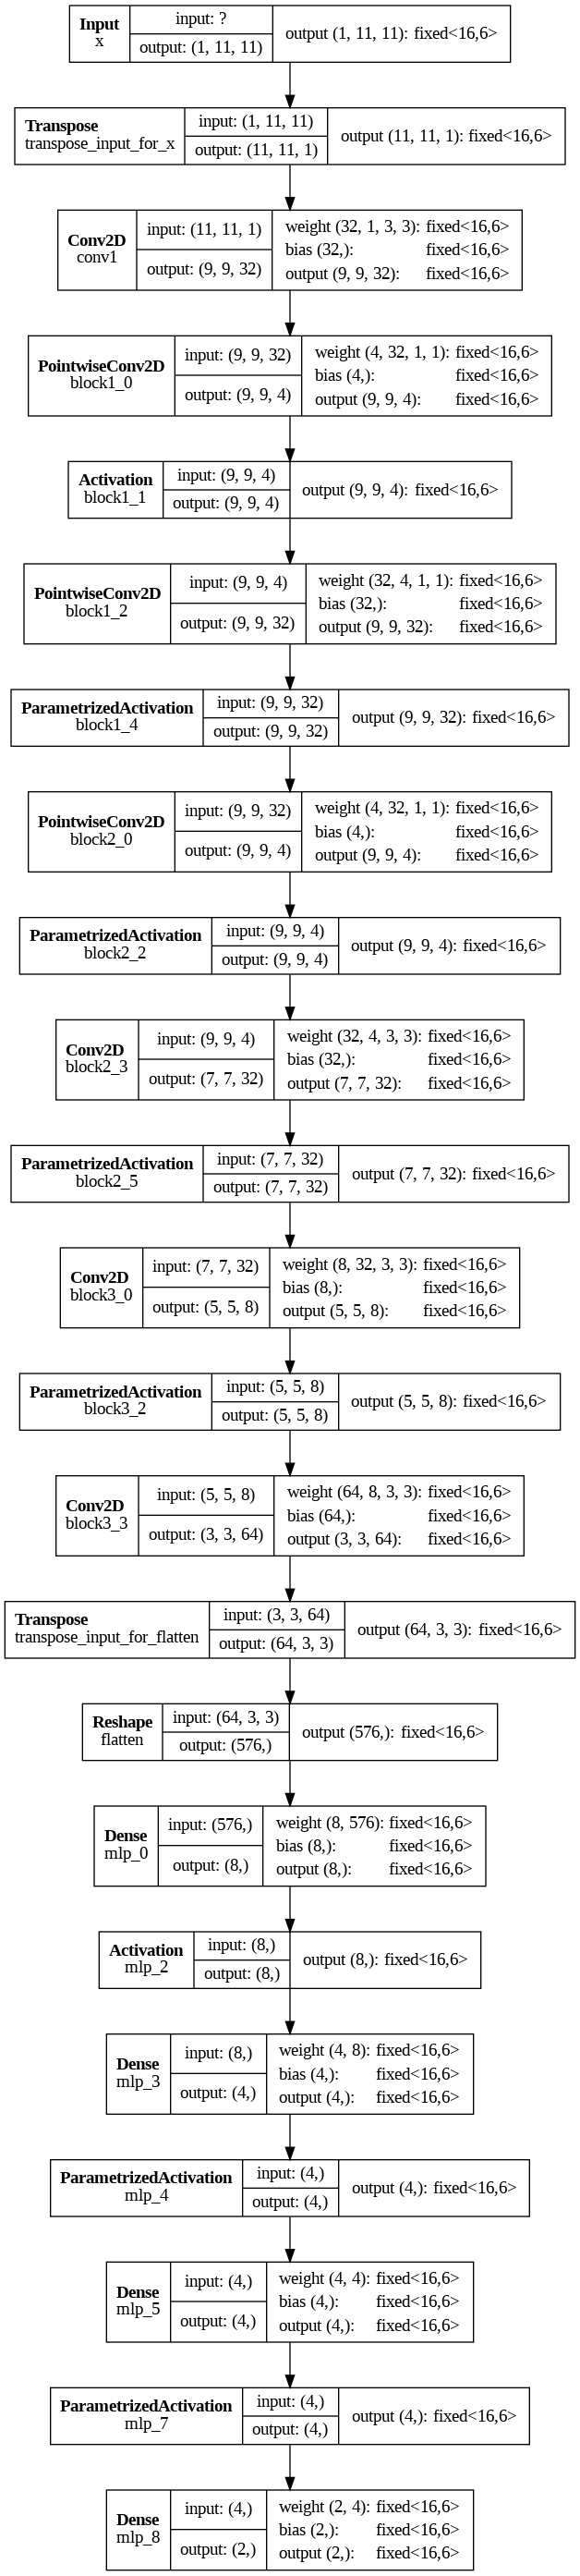

In [ ]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [ ]:
# need to create a new method for hls, not same as pytorch format
  # need to change get_performance

def get_performance_hls(hls_model, dataloader, psz=11):
    distances = []  # Initialize an empty list to store distances for each batch.
    for features, true_locs in dataloader:  # Iterate over batches of data.
        # Convert PyTorch tensors to NumPy arrays for compatibility with hls4ml.
        features_numpy = features.numpy()
        # Use the hls_model's predict method to get predictions from the NumPy array inputs.
        preds = hls_model.predict(features_numpy)
        # Calculate Euclidean distance between predictions and true locations, scaled by psz.
        distance = np.sqrt(np.sum((preds - true_locs.numpy()) ** 2, axis=1)) * psz
        distances.extend(distance)  # Add the distances for this batch to the list.

    mean_distance = np.mean(distances)  # Calculate the mean of all distances.
    return mean_distance


In [ ]:
# # copied this method below to compare the the hls implementation above
# # this is the pytorch method and should be commented out

# def get_performance(model, dataloader, device, psz=11):
#     distances = []  # Initialize an empty list to store distances for each batch.
#     with torch.no_grad():  # Disable gradient computation
#         for features, true_locs in dataloader:  # Iterate over batches of data.
#             features = features.to(device)  # Move features to the specified device (CPU/GPU).
#             preds = model(features)  # Get predictions using the PyTorch model.
#             preds = preds.cpu().numpy()  # Move predictions back to CPU and convert to NumPy arrays.

#             # Calculate Euclidean distance between predictions and true locations, scaled by psz.
#             distance = np.sqrt(np.sum((preds - true_locs.numpy()) ** 2, axis=1)) * psz
#             distances.extend(distance)  # Add the distances for this batch to the list.

#     mean_distance = np.mean(distances)  # Calculate the mean of all distances.
#     return mean_distance

In [ ]:
hls_model.compile()

Writing HLS project
Done


In [ ]:
# X_test = np.ascontiguousarray(test_loader)
# y_hls = hls_model.predict(X_test)

mean_distance_hls = get_performance_hls(hls_model, test_loader, psz=11)
print('HLS Mean Distance: ', mean_distance_hls)
print('Mean Distance: ', mean_distance)

HLS Mean Distance:  0.39590603
Mean Distance:  0.40206024


In [ ]:
# run to save the compiled hls model
hls_model.write()

Writing HLS project
Done


In [ ]:
# # Load the configuration
# with open('synthesis_out/test', 'r') as f:
#     hls_config = json.load(f)

## Vivado Use

In [ ]:
hls_model.build(csim=False)

In [ ]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

## py file

In [ ]:
# Load in the pytorch model, convert to HLS, compile the HLS model, then synthesize the HLS model with Vivado

import torch
import torch.nn as nn
import numpy as np
import hls4ml

# Model architecture

class NAC(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.block1 = nn.Sequential(
            nn.Conv2d(32, 4, 1, 1), #nn.Linear(32, 4), #Point-wise Convolution
            nn.ReLU(),
            nn.Conv2d(4, 32, 1, 1), #nn.Linear(4, 32), #Point-wise Convolution
            nn.BatchNorm2d(32),
            nn.LeakyReLU() #nn.LeakyReLU() (tried out to see if would get a smaller delta is used relu - not the case)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 4, 1, 1), #nn.Linear(32, 4), #Point-wise Convolution
            nn.BatchNorm2d(4),
            nn.LeakyReLU(), #nn.GELU(), (hls4ml not supported)
            nn.Conv2d(4, 32, 3, 1),
            nn.BatchNorm2d(32), #nn.LayerNorm((32, 7, 7)), (hls4ml not supported)
            nn.LeakyReLU() #nn.GELU() (hls4ml not supported)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 8, 3, 1),
            nn.BatchNorm2d(8), #nn.LayerNorm((8, 5, 5)), (hls4ml not supported)
            nn.LeakyReLU(), #nn.GELU(), (hls4ml not supported)
            nn.Conv2d(8, 64, 3, 1),
        )
        self.flatten = nn.Flatten() # added this for hls4ml support
        self.mlp = nn.Sequential(
            nn.Linear(576, 8),
            nn.BatchNorm1d(8), #nn.LayerNorm((8)), (hls4ml not supported)
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.LeakyReLU(), #nn.GELU(), (hls4ml not supported)
            nn.Linear(4,4),
            nn.BatchNorm1d(4), #nn.LayerNorm((4)), (hls4ml not supported)
            nn.LeakyReLU(), #nn.GELU(), (hls4ml not supported)
            nn.Linear(4,2),
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x) #torch.flatten(x,1) # removed this as hls4ml does not support it
        x = self.mlp(x)
        return x

# Define the model
model = NAC()

# Model's state dictionary is saved in 'model_weights.pth'
model_weights_path = 'model_weights_300_epochs.pth'

model.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')))

model.eval()

# Generate initial configuration
config = hls4ml.utils.config_from_pytorch_model(model, granularity='model')

# Set io_type to 'io_stream' for the entire model
config['Model']['IOType'] = 'io_stream'

# Set strategy to 'Resource' for the entire model
config['Model']['Strategy'] = 'Resource'

# Set reuse factor to 32 for the entire model
config['Model']['ReuseFactor'] = 4 # changed from 32 to 4, crashed with 34

# Print the modified configuration
print("-----------------------------------")
print("Configuration")
print(config)  # Use print_dict(config) if you prefer a more structured output
print("-----------------------------------")

# Convert the PyTorch model to HLS model with the specified configuration
hls_model = hls4ml.converters.convert_from_pytorch_model(
    model,
    input_shape=(None, 1, 11, 11),
    hls_config=config,
    output_dir='model_draft/hls4ml_prj',
    part='xcu250-figd2104-2L-e'
)

# Compile the HLS model
hls_model.compile()

# Synthesize (with Vivado)
hls_model.build(csim=False)

# Check the reports
hls4ml.report.read_vivado_report('model_draft/hls4ml_prj/')

-----------------------------------
Configuration
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 4, 'InputsChannelLast': False, 'TransposeOutputs': True, 'Strategy': 'Resource', 'IOType': 'io_stream'}}
-----------------------------------
Interpreting Model ...
Topology:
Layer name: conv1, layer type: Conv2D, input shape: [[None, 1, 11, 11]]
Layer name: block1_0, layer type: Conv2D, input shape: [[None, 32, 9, 9]]
Layer name: block1_1, layer type: Activation, input shape: [[None, 4, 9, 9]]
Layer name: block1_2, layer type: Conv2D, input shape: [[None, 4, 9, 9]]
Layer name: block1_3, layer type: BatchNormalization, input shape: [[None, 32, 9, 9]]
Layer name: block1_4, layer type: LeakyReLU, input shape: [[None, 32, 9, 9]]
Layer name: block2_0, layer type: Conv2D, input shape: [[None, 32, 9, 9]]
Layer name: block2_1, layer type: BatchNormalization, input shape: [[None, 4, 9, 9]]
Layer name: block2_2, layer type: LeakyReLU, input shape: [[None, 4, 9, 9]]
Layer name: block2_3, lay

Exception: Vivado HLS installation not found. Make sure "vivado_hls" is on PATH.